We received the data in 5 different csv files. After we had all of the data, we then started organizing 
and cleaning the data in the .csv files. We changed some field names to make joining the data together easier. After joining
the data and doing some more cleaning we had one final complete dataframe with all of the data included. The data was joined 
according to the user addresses.

In [2]:
import pandas as pd
import numpy as np

data1 = pd.read_csv("071a9bf4-29dc-4a10-96f4-1b995c88c20b.csv") #interacted 1, vaja 0-id tekitada, DONE
data2 = pd.read_csv("433d73df-1cae-47ee-88b1-6f585eb32adc.csv") #weekly txs mainnet, nan -> 0, DONE
data3 = pd.read_csv("4cdb4b81-5b24-4ddc-be7c-4c4678145f51.csv") #DEX.TRADES_transactions txs, DONE
data4 = pd.read_csv("7bc89bae-41bb-4a82-8e02-c6f3934dc353.csv") #ENS, vaja ritta 0-id tekitada, DONE
data5 = pd.read_csv("b7f4f21d-0288-4482-af84-1f807d37b384.csv")

df_m1 = pd.merge(data1,data2, on="address",how="outer")
df_m2 = pd.merge(df_m1,data3, on="address",how="outer")
df_m3 = pd.merge(df_m2,data4, on="address",how="outer")
df = pd.merge(df_m3,data5, on="address",how="outer")
              
df = df.drop(columns=['address'], axis = 1)

df[['NFT_class_bought','NFTclass_sold','DEX_vol_class']] = df[['NFT_class_bought','NFTclass_sold','DEX_vol_class']].fillna(value="0")
df.fillna(0,inplace=True)

df_c = df.copy()
df_c = df_c.drop(columns=['NFT_class_bought','NFTclass_sold','DEX_vol_class'],axis=1)

df = df.drop(columns=["NFT_sum_bought","NFT_sum_sold","DEX_vol_traded"], axis = 1)

df.head()

,NFT_class_bought,NFT_txs_bought,NFTclass_sold,NFT_txs_sold,weekly_txs mainnet,DEX_vol_class,DEX_transactions,ens,interacted
0,10K+,229.0,10K+,296.0,34.833333,0,2.000000,1.0,0.0
1,10K+,497.0,10K+,413.0,95.384615,0,0.000000,1.0,1.0
2,10K+,269.0,10K+,482.0,45.538462,0,2.184211,1.0,1.0
3,10K+,132.0,10K+,84.0,16.500000,0,0.000000,1.0,0.0
4,10K+,31.0,10K+,16.0,9.307692,0,0.000000,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

In [4]:
data_dum = pd.get_dummies(df)
train, test = train_test_split(data_dum, test_size=0.3)

X_train = train.drop(columns=['interacted'], axis=1) 
y_train = train["interacted"] 

X_test = test.drop(columns=['interacted'], axis=1)
y_test = test["interacted"]

#Resampling
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train) 

#Prediction model

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print("Best parms are: ",grid_search.best_params_)

best = grid_search.best_params_

#try hyper-parameter tuning
rf_adasyn = RandomForestClassifier(n_estimators = best["n_estimators"],max_depth = best["max_depth"], min_samples_leaf = best["min_samples_leaf"], min_samples_split = best["min_samples_split"], max_features = best["max_features"]).fit(X_adasyn,y_adasyn) 

probs_adasyn = rf_adasyn.predict(X_test)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parms are:  {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}


In [5]:
print("Accuracy score: "+str(accuracy_score(y_test,probs_adasyn)))
print("Recall score: "+str(recall_score(y_test,probs_adasyn)))
print("Precision score:"+str(precision_score(y_test,probs_adasyn)))
print("With confusion matrix: \n"+str(confusion_matrix(y_test,probs_adasyn)))

Accuracy score: 0.8035363457760314
Recall score: 0.34782608695652173
Precision score:0.3037974683544304
With confusion matrix: 
[[385  55]
 [ 45  24]]


In [6]:
unique, counts = np.unique(df.NFT_class_bought, return_counts=True)
dict(zip(unique, counts))

{'0': 1075, '10K+': 70, '2.5K-10K': 88, '500-2.5K': 111, '>500': 351}

In [7]:
#try correlations
df_corr = df_c.corr()
df_corr["interacted"].sort_values(ascending = False)

interacted            1.000000
NFT_txs_bought        0.081826
NFT_sum_sold          0.071536
NFT_sum_bought        0.056269
NFT_txs_sold          0.052377
weekly_txs mainnet    0.050770
DEX_transactions      0.025351
DEX_vol_traded       -0.003114
ens                  -0.068585
Name: interacted, dtype: float64

In [8]:
d = df_c[df_c["interacted"] == 1].mean()
d

NFT_sum_bought         7103.943511
NFT_txs_bought            7.099502
NFT_sum_sold          16393.723556
NFT_txs_sold              7.104478
weekly_txs mainnet        4.803182
DEX_vol_traded          285.334669
DEX_transactions          0.154782
ens                       0.552239
interacted                1.000000
dtype: float64

In [12]:
b = df_c[df_c["interacted"] == 1].median()
b

NFT_sum_bought        0.0
NFT_txs_bought        0.0
NFT_sum_sold          0.0
NFT_txs_sold          0.0
weekly_txs mainnet    3.0
DEX_vol_traded        0.0
DEX_transactions      0.0
ens                   1.0
interacted            1.0
dtype: float64

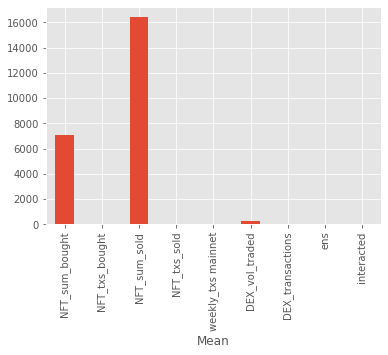

In [30]:
import matplotlib.pyplot as plt

# allows to output plots in the notebook
%matplotlib inline 

# Set the default style
plt.style.use("ggplot") 
plt.xlabel("Mean")
d.plot(kind='bar')

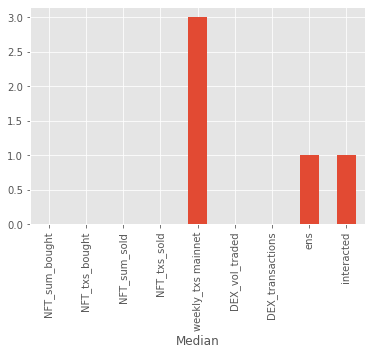

In [31]:
import matplotlib.pyplot as plt

# allows to output plots in the notebook
%matplotlib inline 

# Set the default style
plt.style.use("ggplot") 
plt.xlabel("Median")
b.plot(kind='bar')